# <u> COGS 188 Assignment 2 </u>

In this Assignment we will be implementing both **K-means clustering** and **EM Algorithm** on 2D points. Both of these algorithms are methods to divide the given set of points into **k** clusters (groups), such that all points in a cluster are "close together". The number **k** is chosen in advance manually and is not computed by the algorithms.

The main difference between the two algorithms is that K-means is a "hard clustering" method, whereas EM is used to create a "soft clustering". This means that in K-means, each point is either 100% *in* a cluster, or not in it. Whereas in EM Algorithm, we compute a (Gaussian) probability distribution for each cluster. We can use these to compute the probability for a point to be in a cluster, for all pairs of points and clusters. So for each point, we find the probability that it is in each of the clusters.

# PART 1 - Kmeans

K-means clustering is a type of unsupervised learning, which is used with unlabeled dataset. The goal of this algorithm is to find K groups in the data. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the K-means clustering algorithm are:

- The centroids of the K clusters, which can be used to label new data
- Labels for the training data (each data point is assigned to a single cluster)

K-means works by defining spherical clusters that are separable in a way so that the mean value converges towards the cluster center. Because of this, K-Means may underperform sometimes.

<b><u>Use Cases:</u></b>
- Document Classification
- Delivery Store Optimization
- Customer Segmentation
- Insurance Fraud Detection etc.

### <u> Algorithm </u>:

Κ-means clustering algorithm inputs are the number of clusters Κ and the data set. Algorithm starts with initial estimates for the Κ centroids, which can either be randomly generated or randomly selected from the data set. The algorithm then iterates between two steps:

<b><u>1. Data assigment step:</u></b>

Each centroid defines one of the clusters. In this step, each data point based on the squared Euclidean distance is assigned to its nearest centroid. If $c_i$ is the collection of centroids in set C, then each data point x is assigned to a cluster based on

$$\underset{c_i \in C}{\min} \; dist(c_i,x)^2$$

where dist( · ) is the standard (L2) Euclidean distance.

<b><u>2. Centroid update step:</u></b>

Centroids are recomputed by taking the mean of all data points assigned to that centroid's cluster.

The algorithm iterates between step one and two until a stopping criteria is met (no data points change clusters, the sum of the distances is minimized, or some maximum number of iterations is reached). In this assignment, we will use the first criterion, i.e. that no data points change clusters.

<b>This algorithm may converge on a local optimum. </b> Assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

### Generating the data

We will generate 3 datasets to use in this assignment. They are created in the following code, and stored in `X`, `X1` and `X2` respectively. They are each sets of 500 2D points. We store them as matrices of size $500 \times 2$.

Please use these variables `X1`, `X2` and `X3` to run your kmeans and EM in this assignment.

X shape:  (500, 2)


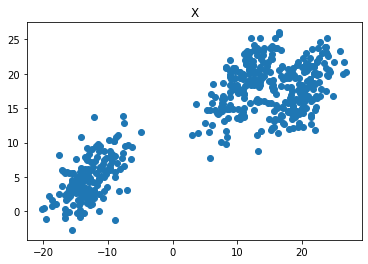

X1 shape:  (500, 2)


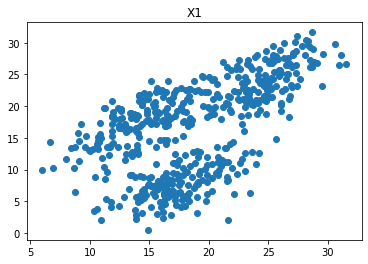

X2 shape:  (500, 2)


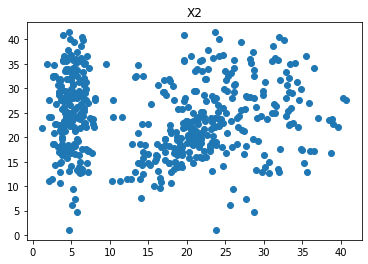

In [3]:
X,Y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)
X = np.dot(X,np.random.RandomState(0).randn(2,2))

print('X shape: ', X.shape)

plt.scatter([x[0] for x in X], [x[1] for x in X])
plt.title('X')
plt.show()

centers = [[4, 7], [9, 9], [9, 2]]

X1,Y1 = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=centers)
X1 = np.dot(X1,np.random.RandomState(0).randn(2,2))

print('X1 shape: ', X1.shape)

plt.scatter([x[0] for x in X1], [x[1] for x in X1])
plt.title('X1')
plt.show()

centers = [[5, 5]]
X21,Y21 = make_blobs(cluster_std=1.5,random_state=20,n_samples=200,centers=centers)
X21 = np.dot(X21, np.array([[1.0, 0], [0, 5.0]]))

centers = [[5, 5]]
X22,Y22 = make_blobs(cluster_std=1.5,random_state=20,n_samples=200,centers=centers)
X22 = np.dot(X21, np.array([[5.0, 0], [0, 1.0]]))

centers = [[7, 7]]
X23, Y23 = make_blobs(cluster_std=1.5,random_state=20,n_samples=100,centers=centers)
X23 = np.dot(X23, np.random.RandomState(0).randn(2,2))

X2 = np.vstack((X21, X22, X23))

print('X2 shape: ', X2.shape)

plt.scatter([x[0] for x in X2], [x[1] for x in X2])
plt.title('X2')
plt.show()

### KMeans Algorithm Class

Now we will start coding the K-means algorithm. All the code will be in the `KmeansModel` class.

We start by initializing the class. To initialize, we specify the data matrix **X** and the number of clusters **k**. **X** is a matrix of shape $N \times 2$, as we have **N** points each with x and y coordinates. We set `self.N` as the number of points and `self.dim` as the number of dimensions (2).

We need to store $k$ centroids, one for each cluster. We shall store them as a $K \times 2$ matrix in `self.centroids`. We initialize the centroids to be random points from our dataset.

If the model is not converging, we stop running it if the number of iterations has reached `max_iters`.

Finally we plot the data with the initial (random) clustering.

In [4]:
class KmeansModel:
    
    def __init__(self, X, k, max_iters):
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = X.shape[1]
        self.N = X.shape[0]
        
        centroid_indices = np.random.RandomState(2).permutation(X.shape[0])[:k]
        self.centroids = X[centroid_indices]
        
        initial_labels = self.get_labels(self.X, self.centroids)
        self.plot_data(initial_labels, 'Data with initial random clusters')

To color each point according to its cluster, we need to specify a **label** for each point. A label is just an integer `>= 0`. The label for all points in the same cluster must be the same.

So we make a function `get_labels(X, centroids)`. This function takes in our $N \times 2$ data matrix **X**, and our $k \times 2$ centroid matrix. It should return a $N \times 1$ numpy array `labels`, such that `labels[i]` is the index of the cluster of the `i`'th point.

To do this, we should iterate over all the points. For each point we should iterate over all the centroids, and choose the one which is the closest (least Euclidean distance) to the point. We can simply use the index of that centroid (`0 <= index < k`) as the label for that point. We should finally return the array of labels for all the points.

In [23]:
def get_labels(self, X, centroids):
    
    labels = []
    for point in X:
        min_distance = 10**7
        min_index = 0
        for i in range(centroids.shape[0]):
            distance = np.sqrt(np.sum((point-centroids[i])**2))
            if distance < min_distance:
                min_index = i
                min_distance = distance

        labels.append(min_index)
    return np.array(labels)

KmeansModel.get_labels = get_labels # We define this function to be a function of the KmeansModel class.

Here we have a function to plot our data. This function takes in the labels, and colors each point according to its cluster, as defined by the labels we computed above.

In [20]:
def plot_data(self, labels, title):
    fig = plt.figure(figsize=(20,20))
    ax0 = fig.add_subplot(111)
    ax0.scatter(self.X[:,0], self.X[:,1], c=labels)
    ax0.set_title(title)
    
KmeansModel.plot_data = plot_data

Now we have our main function which runs the K-means algorithm. This repeatedly performs the two steps of the Kmeans algorithm (Data Assignment and Centroid Update). You should stop when there is no change in the cluster centroids, ie they are the same as the previous step. 

We also stop after a certain number of max iterations if the algorithm is not converging.

After convergence, we plot the data again with the new cluster centers and labels.

In [69]:
def run(self):
    iters = 0
    while True:
        labels = get_labels(self,self.X,self.centroids)
        new_centroids = np.ones(self.k)
        X_labeled = np.vstack((labels.T,X.T))
        for i in range(self.k):
            new_centroids[i] = np.mean(X_labeled[i])

        if np.all(labels == get_labels(self,self.X,new_centroids)):  
            break
            
        if iters == self.max_iters:
            break

        self.centroids = new_centroids
        
        iters += 1

    final_labels = self.get_labels(self.X, self.centroids)
    self.plot_data(final_labels, 'Final clusters w/ ' + str(iters) + ' iters')
    
KmeansModel.run = run

Finally, we create an instance of `KmeansModel` and run our algorithm on some data.

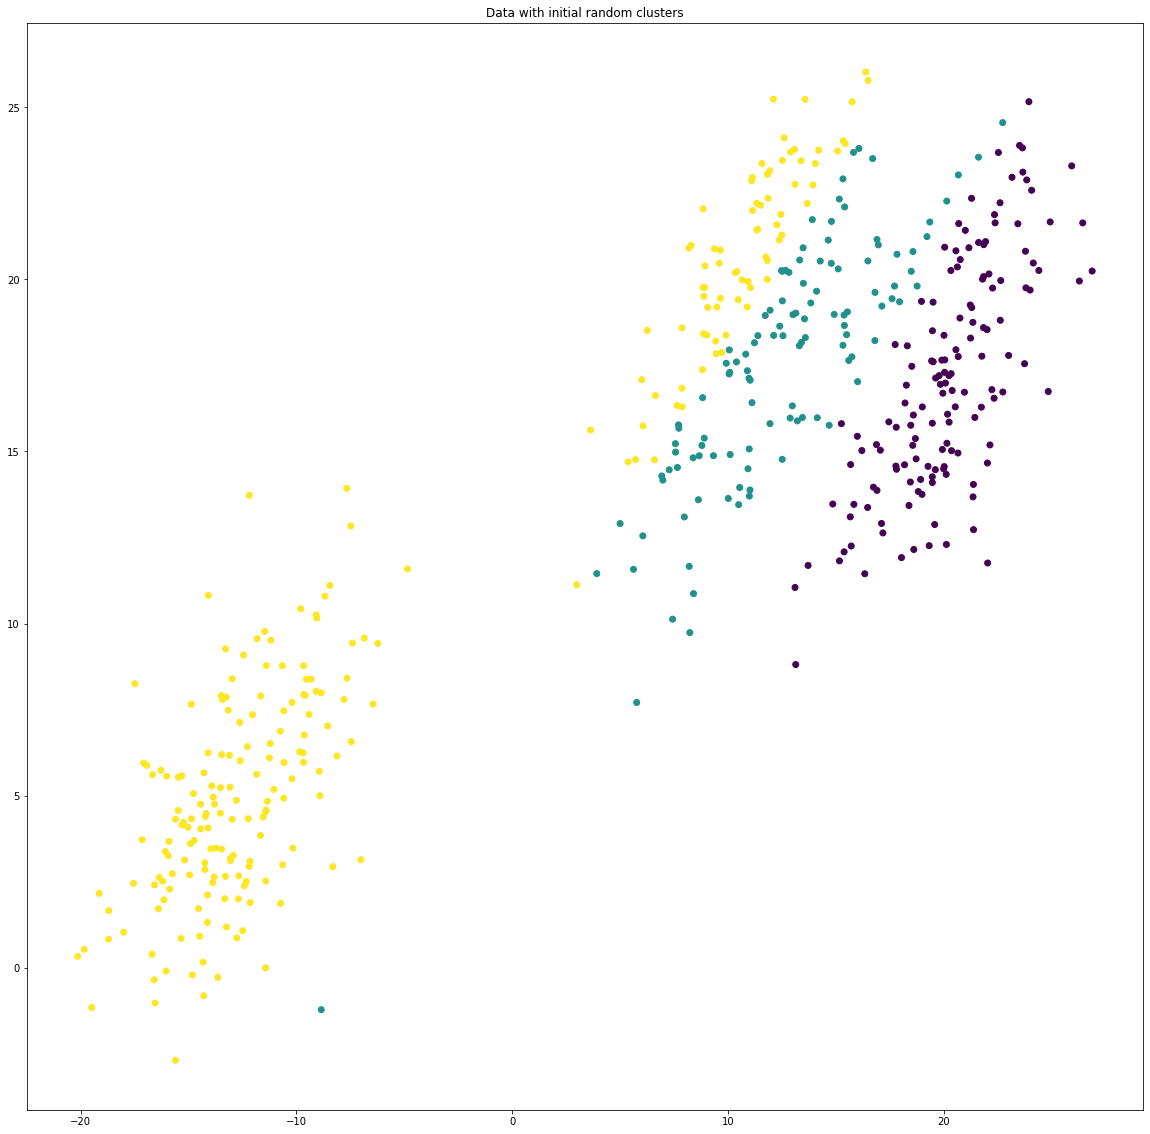

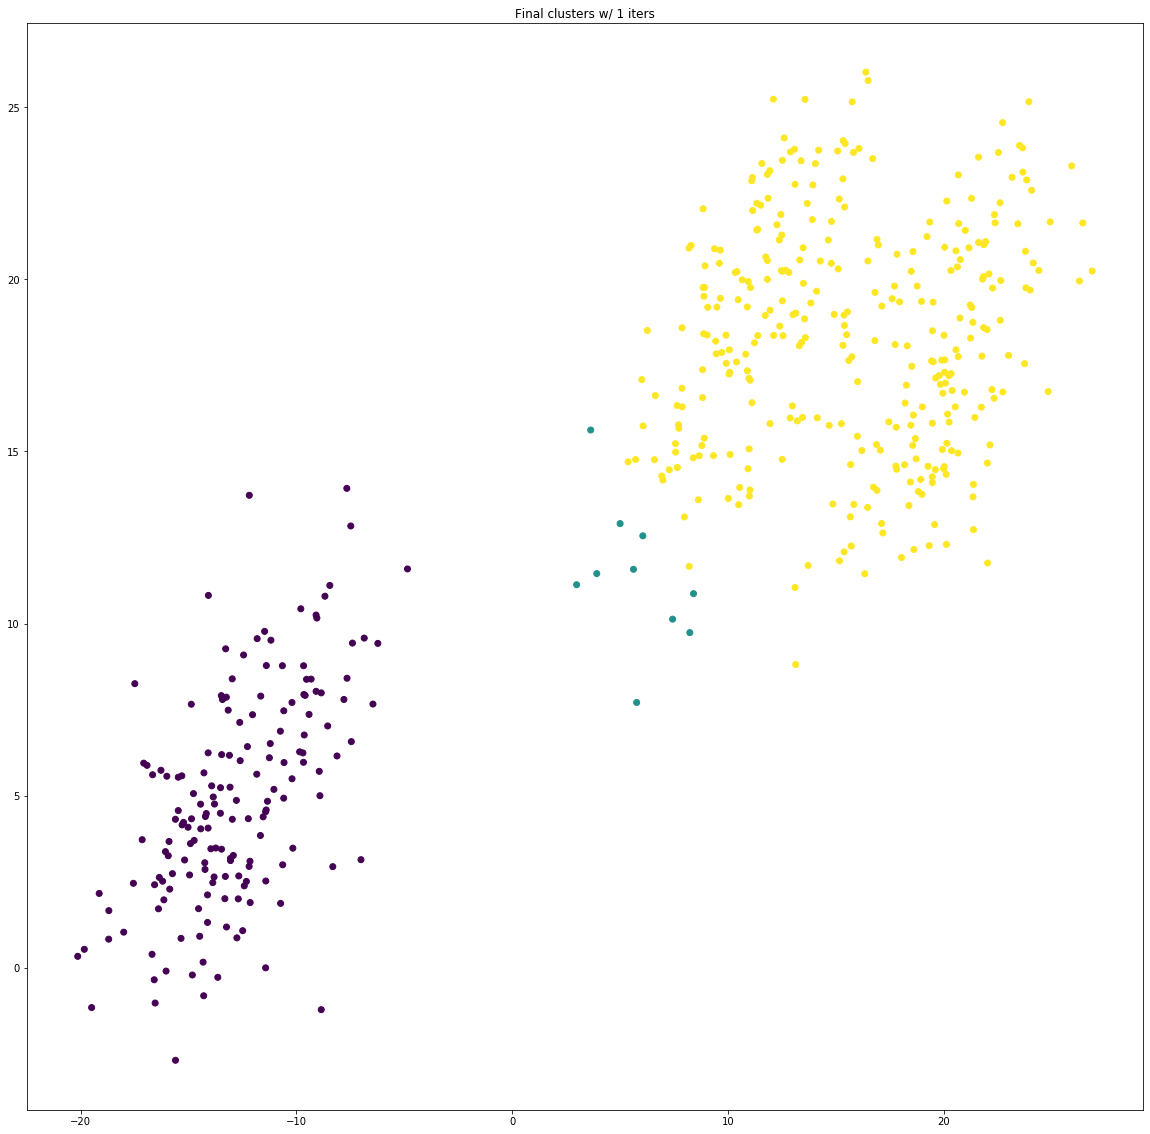

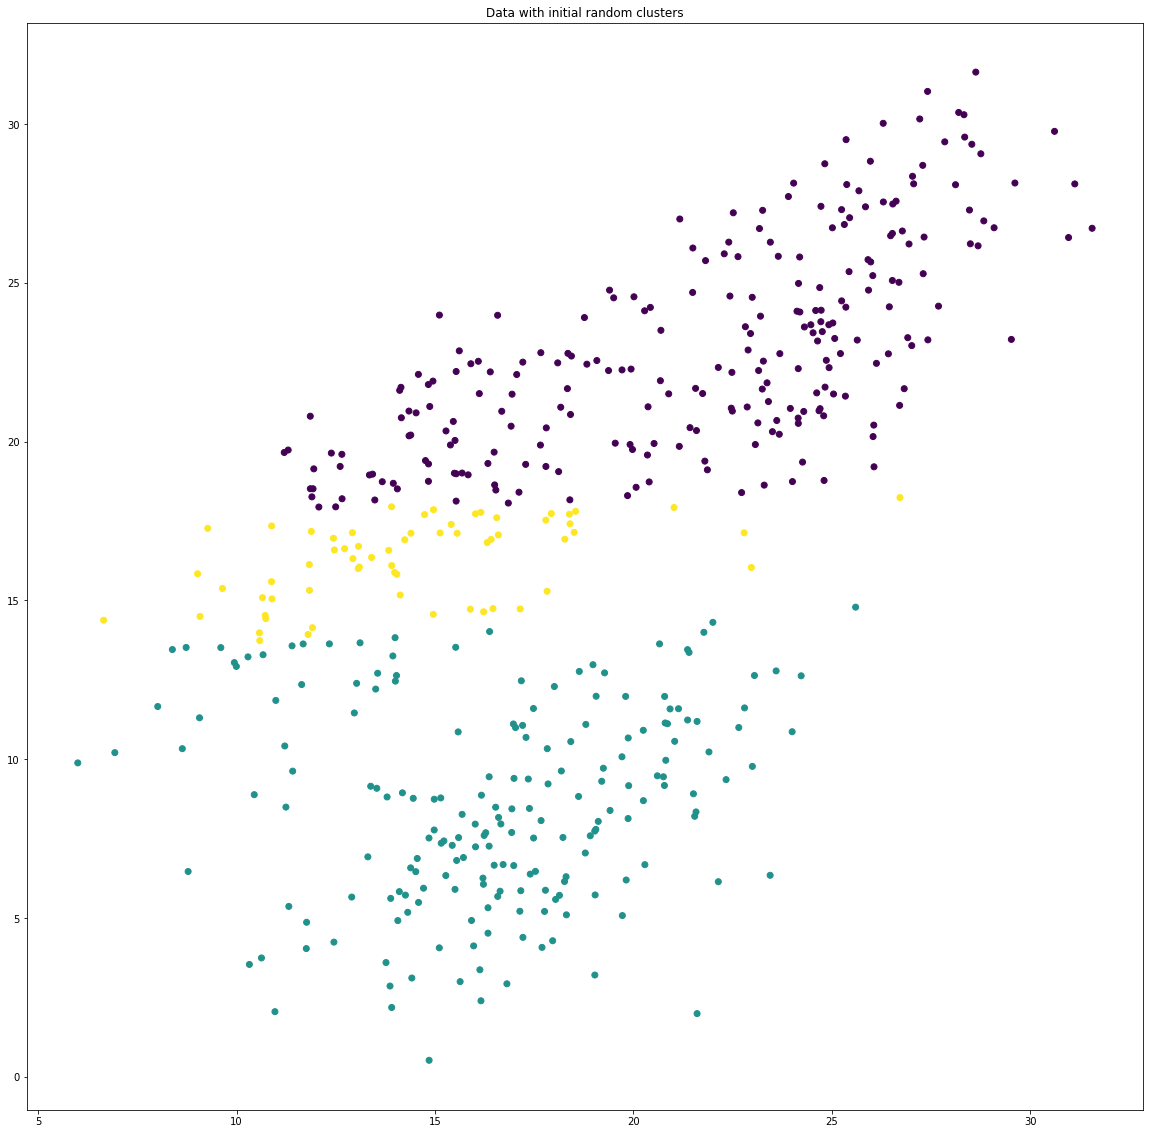

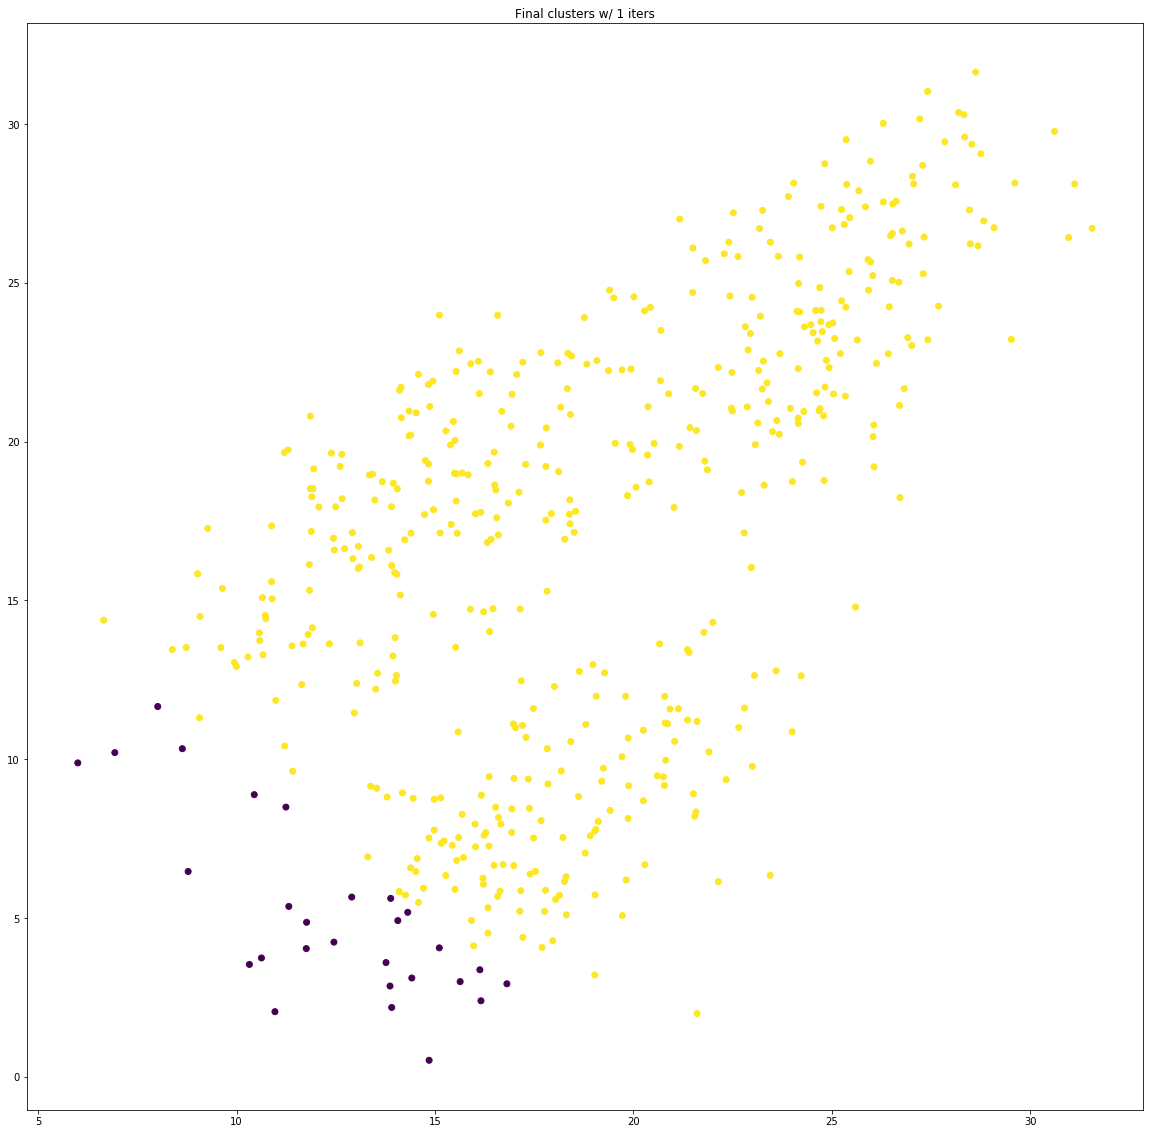

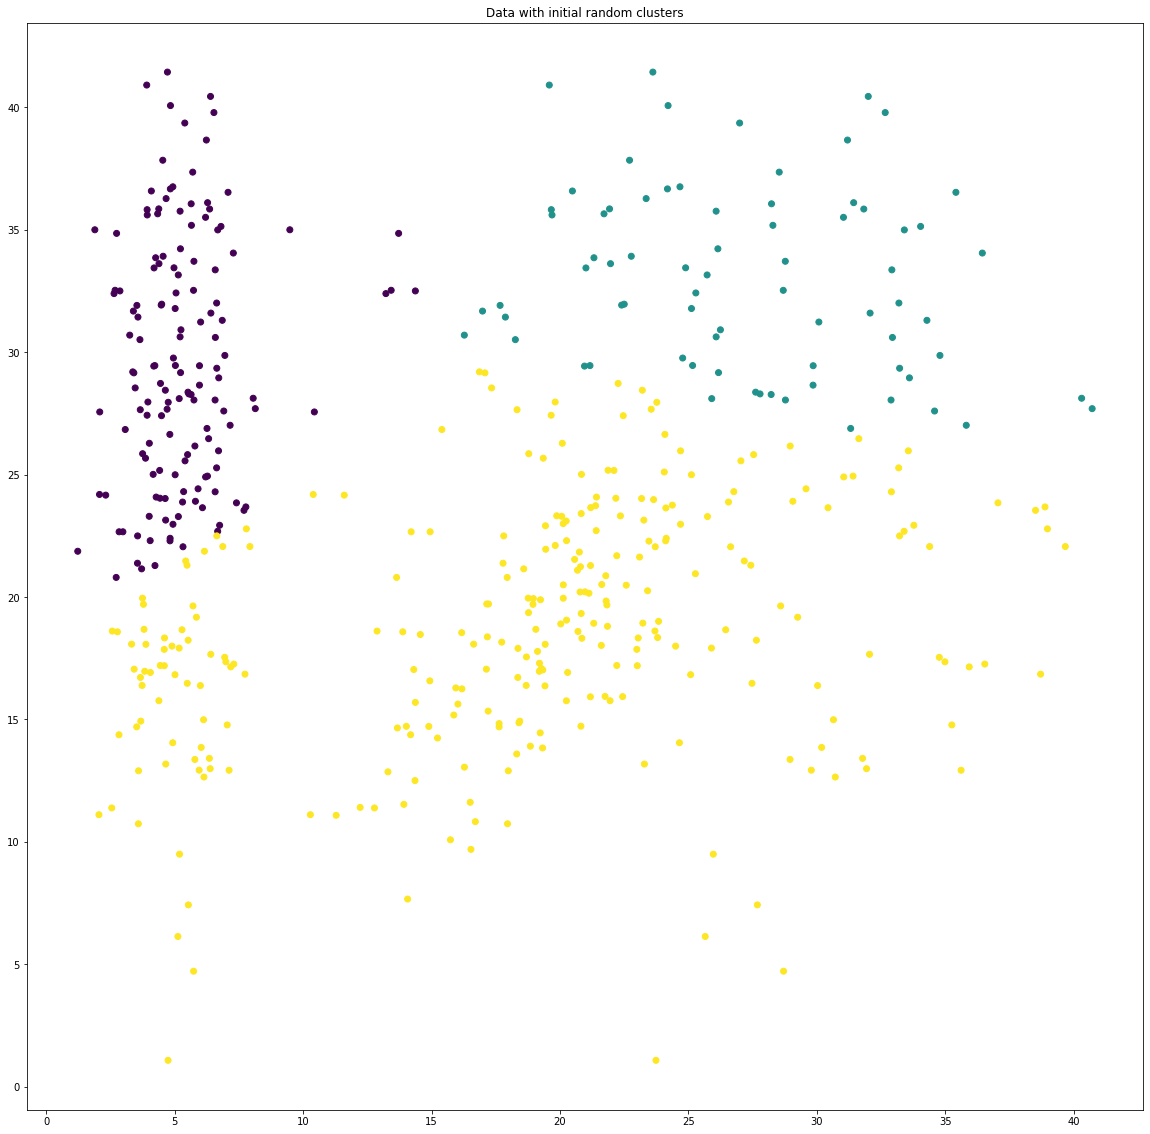

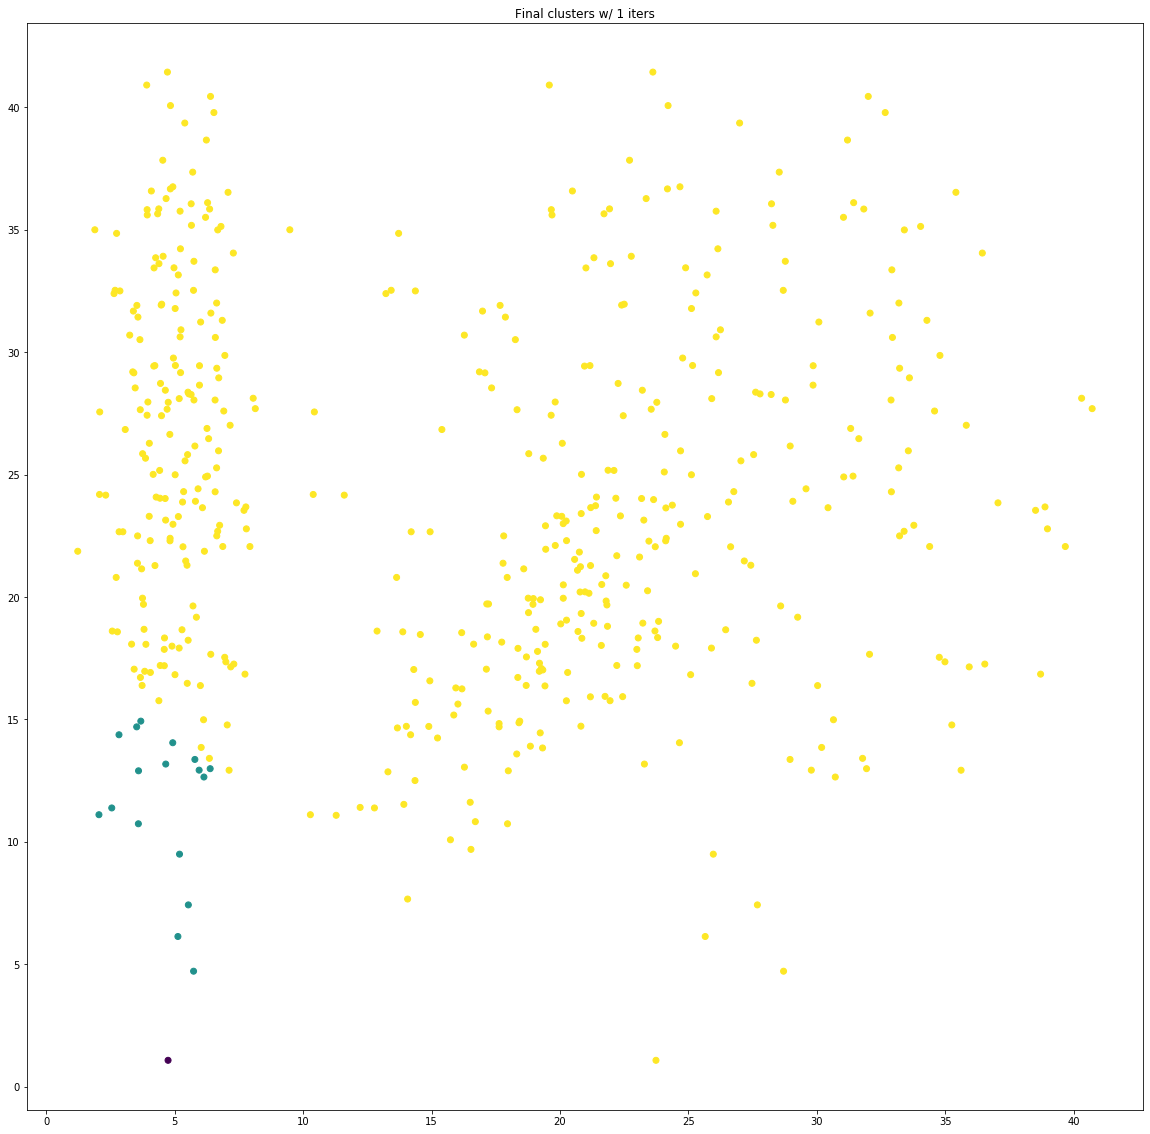

In [70]:
km1 = KmeansModel(X, 3, 100)
km1.run()

km2 = KmeansModel(X1, 3, 100)
km2.run()

km3 = KmeansModel(X2, 3, 100)
km3.run()

# PART 2 - EM

EM Algorithm finds clusters by treating each cluster as a 2D Gaussian distribution, and then fits the parameters of each distribution to accurately model the data. The goal is to find optimal parameters for each of the Gaussians which model the data accurately.

<img src="em1.PNG">

Each cluster distribution is of the form $\pi_c \mathcal{N}(\mu_c, \sum_c)$, for each cluster $c, 0 \leq c < k$. For each cluster, we have the parameters $\mu_c, \pi_c$ and $\sum_c$.

$\pi_c$ denotes the cluster "strength" or "size" for each cluster. It represents the prior strength for a cluster, i.e. how likely it is that any point in the dataset belongs to that cluster.

$\mu_c$ denotes the cluster mean (a 2D point). The cluster distribution is centered around this point.

$\sum_c$ denotes the cluster covariance. Covariance is a generalization of variance $\sigma$ to multiple variables (in our case, 2D coordinates). It is a $2 \times 2$ matrix which represents the spread of each of the $x$ and $y$ coordinates.

The EM Algorithm has 2 steps, which are repeated till convergence:
- Expectation: We treat all of the cluster parameters as fixed. We then compute the probabilities of each point belonging to each cluster.
- Maximization: We treat the cluster probabilities as fixed and update the distribution parameters.

We start by initializing our EMModel class. This is the main class which will store our data and distribution parameters. We will also write all the functionality in it.

`X` is a matrix of size $N \times 2$

`k` is the number of clusters we want (3 in our case).

`max_iters` is the number of iterations we will run the algorithm for.

`self.dim` is the number of dimensions (2 in our case).

`self.N` is the number of points in the dataset (500 in our case).

`self.mu` stores all the cluster means. Size is $k \times 2$, as we have to store one point for each cluster. It is initialized to random points lying in the dataset.

`self.pi` stores all the cluster priors (strengths). Size is $k \times 1$, as it is just one number for each cluster. It is initialized to $\frac{1}{k}$ for each cluster.

`self.sigma` stores all the cluster covariance matrices. Size is $k \times 2 \times 2$, as we have to store a $2 \times 2$ matrix for each cluster. It is initialized to diagonal matrices with diagonal value $5.0$.

### Useful functions

To draw a value from a multivariate normal distribution, use the `scipy.stats.multivariate_normal` function. For example, to draw a value from a normal distribution with mean `mu` and covariance matrix `sigma`, you can use the following code:

`val = multivariate_normal(mean=mu, cov=sigma).pdf(X)` where `X` is an $N \times 2$ matrix.

In [58]:
class EMModel:
    
    def __init__(self, X, k, max_iters):
        """
        This function initializes our parameters (mu, pi and sigma) and plots our data points.
        """
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = self.X.shape[1] # Equals 2, as we are considering 2D points
        self.N = self.X.shape[0] # Equals the number of points in the dataset
        
        """
        Here we initialize mu, pi and sigma. Mu is k X 2, Pi is k X 1, Sigma is k X 2 X 2
        """
        self.mu = np.random.randint(max(min(self.X[:, 0]), min(self.X[:, 1])), min(max(self.X[:, 0]), max(self.X[:, 1])), size=(self.k, self.dim))
        self.pi = np.ones(self.k) / self.k
        self.sigma = np.zeros((self.k, self.dim, self.dim))
        for i in range(self.k):
            np.fill_diagonal(self.sigma[i], 5.0)
            
        """
        This part is required to plot clusters
        """
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
        
        """
        This variable is required in case the covariance matrix turns out to not be positive semidefinite
        """
        self.sigma_correction = 0.0*np.identity(self.dim)
            
        """
        Finally, let's visualize our data points
        """
        self.plot_data('Initial State')

We define a function `plot_data` to plot our data as well as our clusters. This function plots our data points, and creates a contour plot for each cluster using its `mu` and `sigma` values.

In [59]:
def plot_data(self, title, colors=None):
    """
    This function creates a scatter plot of all the data points. It also creates a contour plot of the probability 
    distributions of each of the clusters (specified by mu, pi and sigma)
    """
    fig = plt.figure(figsize=(20,20))
    ax0 = fig.add_subplot(111)
    ax0.scatter(self.X[:,0], self.X[:,1], c=colors)
    ax0.set_title(title)
    for m,c in zip(self.mu,self.sigma):
        c += self.sigma_correction
        multi_normal = multivariate_normal(mean=m,cov=c)
        ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
        ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
EMModel.plot_data = plot_data

Now we define our "expectation" function. This function's job is to compute $r_{ic}$, which is the probability that point $i$ belongs to cluster $c$ ($0 \leq i < N$, $0 \leq c < k$).

We will store $r_{ic}$ as a matrix of size $N \times k$. (as we have to store a probability for point cluster pair).

$r_{ic}$ is computed as follows:
<img src="ric.png">

To compute it, we basically:
- compute its probability under cluster model $c$
- normalize it to sum to 1 using its probabilities from all the clusters

Finally we should return `r` after computing it.

In [60]:
def expectation(self):
        r = np.zeros((self.N, self.k))
        for mu, sigma, pi, c in zip(self.mu, self.sigma, self.pi, range(self.k)):
            sigma += self.sigma_correction ##YOUR CODE
            multi_normal = multivariate_normal(mean=mu, cov=sigma).pdf(self.X) #YOUR CODE 
            numerator = pi*multi_normal ##YOUR CODE
            denominator = np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(self.X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.sigma + self.sigma_correction)],axis=0)
            r[:, c] = numerator / denominator

        return r
    
EMModel.expectation = expectation

Now we define the "maximization" step in the `maximization` function. This function's job is to take the previously computed $r_{ic}$ and update the parameters $\mu_c, \sum_c$ of each cluster distribution. This is done as follows:
<img src="m1.png">

Here, $N = \sum_{c} N_c$

Basically you should re-compute `mu`, `sigma` and `pi` using the previously computed `r` as per the given formulas.

In [61]:
def maximization(self, r):
    self.mu = []
    self.sigma = []
    self.pi = []

    for c in range(self.k):
        m = np.sum(np.array(r[:,c])) ##
        mu = np.sum(np.array(r[:,c]).reshape(self.N,1)*self.X, axis=0)/m #
        self.mu.append(mu)

        self.pi.append(m/self.N) ##

        self.sigma.append(((1/m)*np.dot((np.array(r[:,c]).reshape(self.N,1)*(self.X-mu)).T,(self.X-mu)))+self.sigma_correction)
        
        
        
EMModel.maximization = maximization

Now we write our main `run()` function which runs the EM Algorithm. This performs `max_iter` iterations of expectation and maximization.

In [62]:
def run(self):
    r = None
    for it in range(self.max_iters):
        r = self.expectation()
        self.maximization(r)

    color_labels = np.argmax(r, axis=1)
    self.plot_data('Final State', color_labels)
    
EMModel.run = run

Finally, we instantiate the `EMModel` class and run the algorithm on some data.

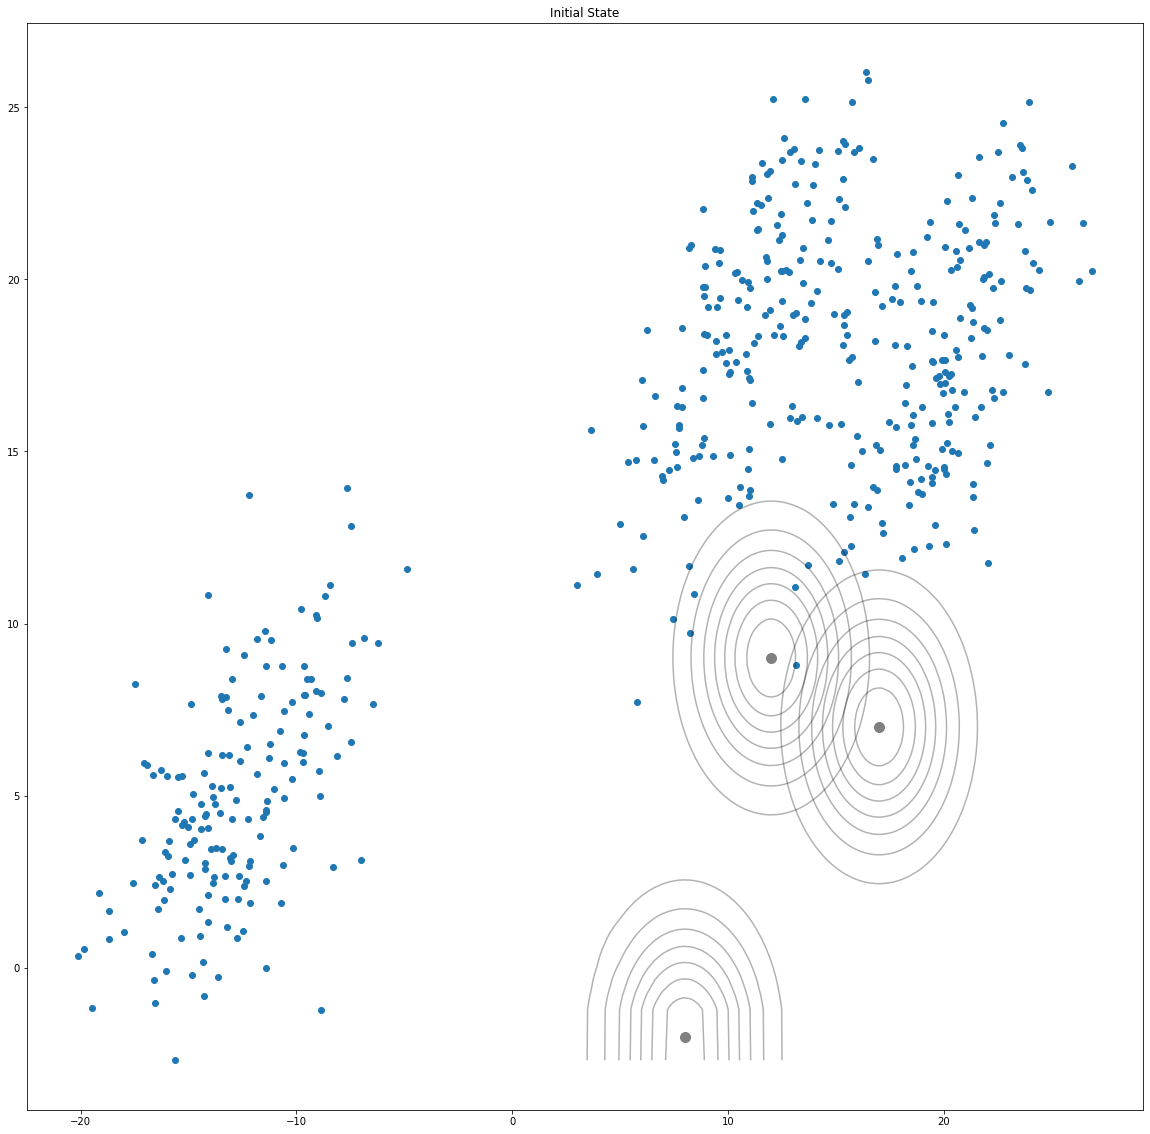

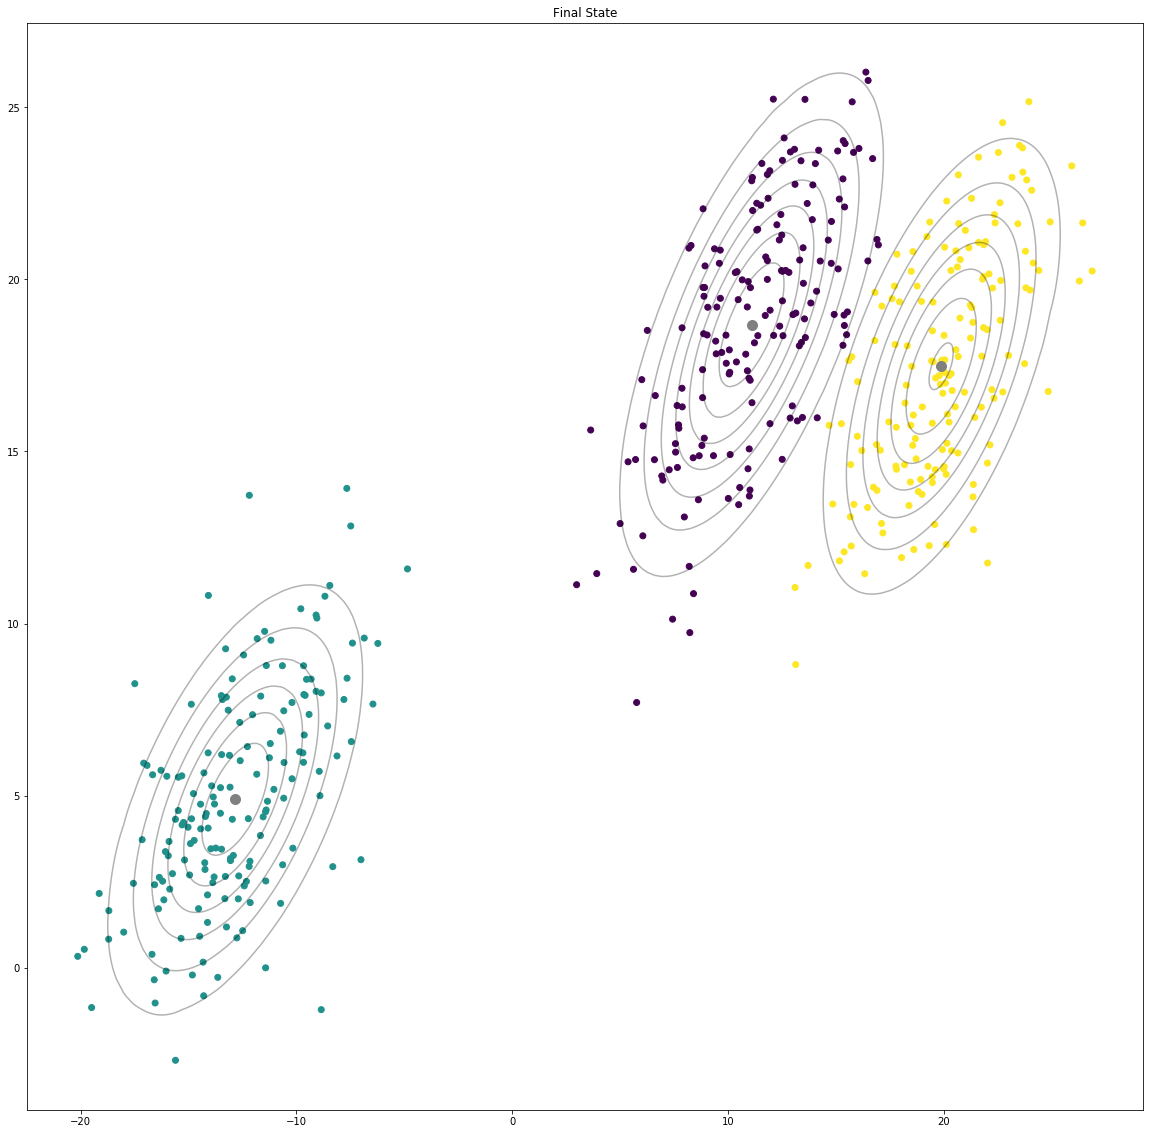

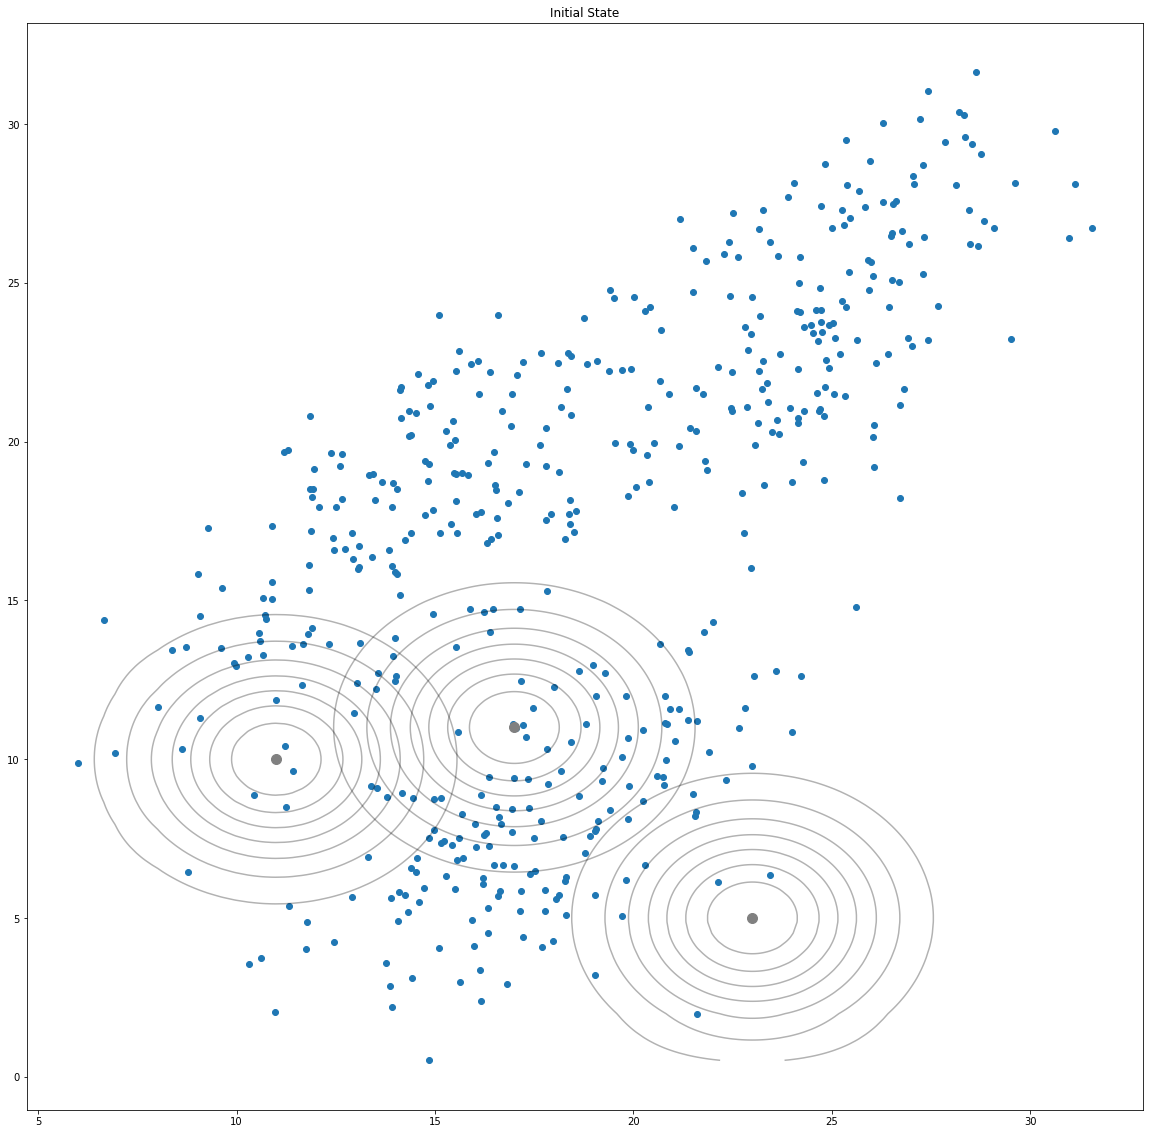

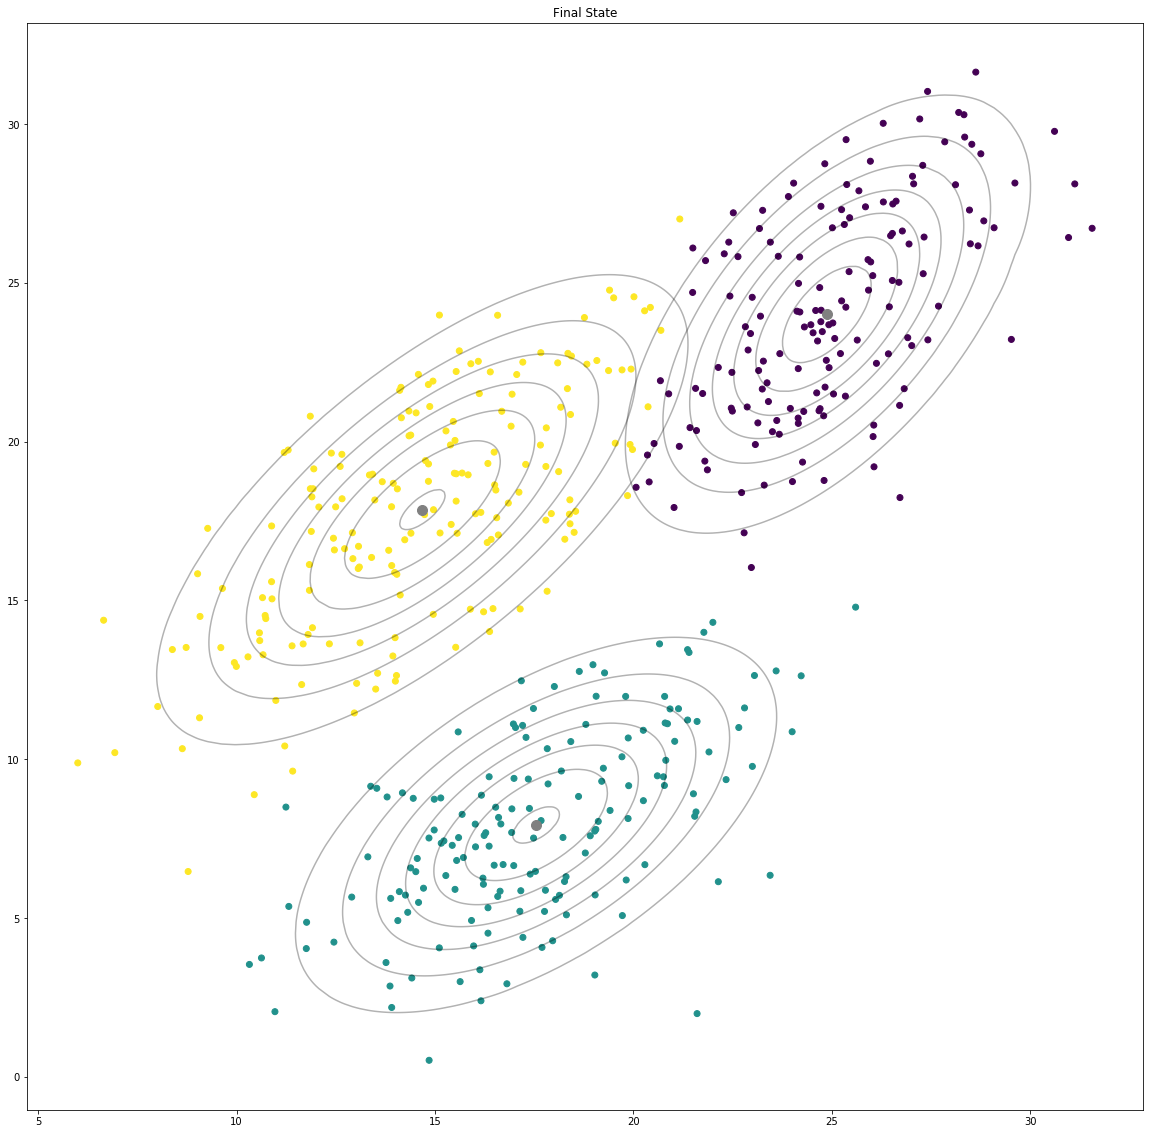

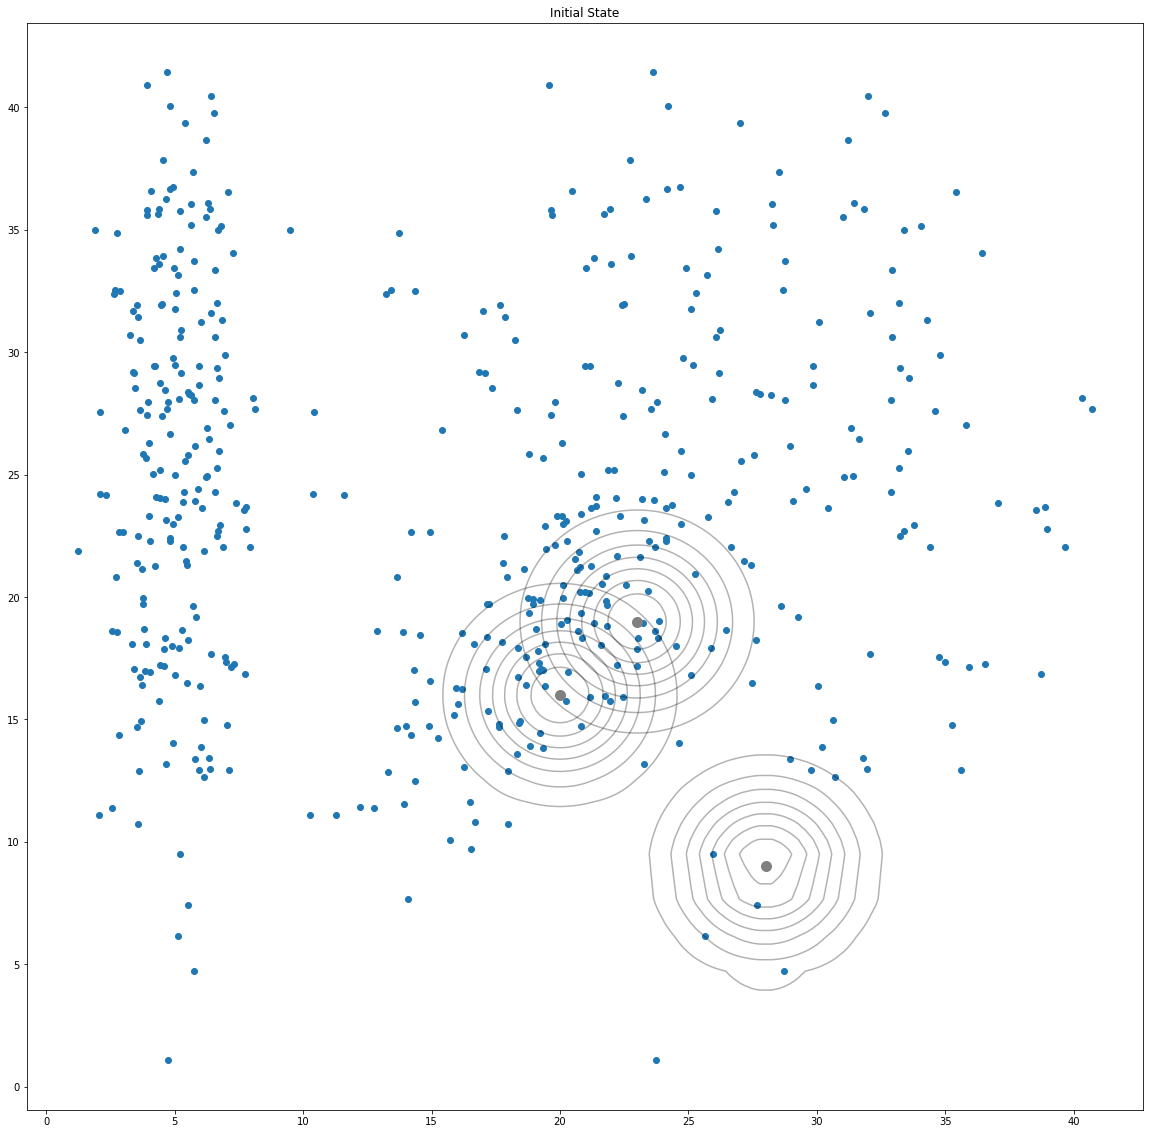

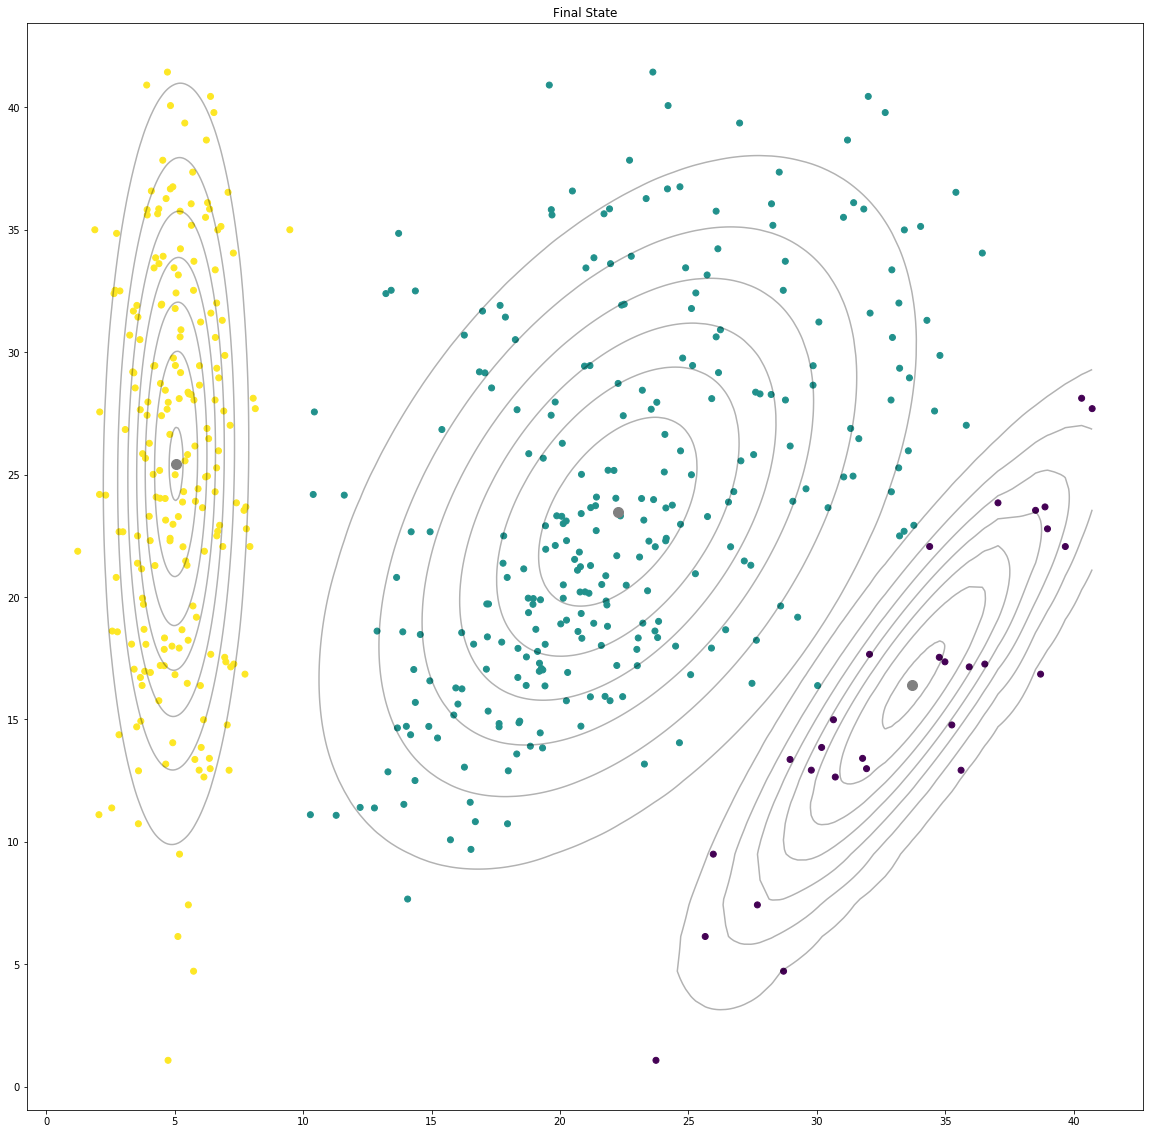

In [63]:
EM = EMModel(X, 3, 50)
EM.run()

EM1 = EMModel(X1, 3, 100)
EM1.run()

EM2 = EMModel(X2, 3, 100)
EM2.run()